In [28]:
import cv2
import os, sys
import numpy as np
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil, random

current_directory = os.getcwd()
while not current_directory.endswith('pneumonia_detection'):
    current_directory = os.path.dirname(current_directory)
root_directory = current_directory
os.chdir(root_directory)
sys.path.insert(0, root_directory)

from src.utils.utils import *

In [29]:
DATA_DIR = os.path.join(root_directory, 'data_processed')

## Check number of files in train, test, and validation sets

### Check number of files in train sets

In [30]:
normal_lungs = [[], [] , []]
pneumonia_lungs = [[], [], []]

In [31]:
data_paths = {
    'train': {
        'NORMAL': os.path.join(DATA_DIR, 'train', 'NORMAL'),
        'PNEUMONIA': os.path.join(DATA_DIR, 'train', 'PNEUMONIA')
    },
    'val': {
        'NORMAL': os.path.join(DATA_DIR, 'val', 'NORMAL'),
        'PNEUMONIA': os.path.join(DATA_DIR, 'val', 'PNEUMONIA')
    },
    'test': {
        'NORMAL': os.path.join(DATA_DIR, 'test', 'NORMAL'),
        'PNEUMONIA': os.path.join(DATA_DIR, 'test', 'PNEUMONIA')
    }
}

In [32]:
file_names = {
    'train': {
        'NORMAL': [],
        'PNEUMONIA': []
    },
    'val': {
        'NORMAL': [],
        'PNEUMONIA': []
    },
    'test': {
        'NORMAL': [],
        'PNEUMONIA': []
    }
}

In [33]:
file_names['train']['NORMAL'] = list_folder(data_paths['train']['NORMAL'])
file_names['train']['PNEUMONIA'] = list_folder(data_paths['train']['PNEUMONIA'])
len(file_names['train']['NORMAL']) , len(file_names['train']['PNEUMONIA'])

(1341, 3875)

### Check number of files in val sets

In [34]:
file_names['val']['NORMAL'] = list_folder(data_paths['val']['NORMAL'])
file_names['val']['PNEUMONIA'] = list_folder(data_paths['val']['PNEUMONIA'])
len(file_names['val']['NORMAL']) , len(file_names['val']['PNEUMONIA'])

(8, 8)

### Check number of files in test sets

In [35]:
file_names['test']['NORMAL'] = list_folder(data_paths['test']['NORMAL'])
file_names['test']['PNEUMONIA'] = list_folder(data_paths['test']['PNEUMONIA'])
len(file_names['test']['NORMAL']) , len(file_names['test']['PNEUMONIA'])

(234, 390)

### Dataset Distribution Summary
| Split | NORMAL | PNEUMONIA | Total |
|-------|--------|-----------|-------|
| Train | 1,341  | 3,875     | 5,216 |
| Val   | 8      | 8         | 16    |
| Test  | 234    | 390       | 624   |

**Note:** 

- The dataset is imbalanced with ~3x more PNEUMONIA samples than NORMAL in the training set.
- There is too little data in validation set.

## Split dataset

In [36]:
INPUT_DIR = os.path.join(root_directory, 'data_processed')
OUTPUT_DIR = os.path.join(root_directory, 'data_processed_new')

TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

In [37]:
if not os.path.exists(INPUT_DIR):
    raise Exception(f"Lỗi: Không tìm thấy folder nguồn '{INPUT_DIR}'")

if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)

for split in ['train', 'val', 'test']:
    for label in ['NORMAL', 'PNEUMONIA']:
        os.makedirs(os.path.join(OUTPUT_DIR, split, label), exist_ok=True)

print("Đang thực hiện chia dữ liệu...", end="\r")

for label in ['NORMAL', 'PNEUMONIA']:
    # Gom ảnh
    files = glob(os.path.join(INPUT_DIR, '*', label, '*.jpeg')) + \
            glob(os.path.join(INPUT_DIR, '*', label, '*.jpg')) + \
            glob(os.path.join(INPUT_DIR, label, '*.jpeg')) + \
            glob(os.path.join(INPUT_DIR, label, '*.jpg'))

    files = list(set(files))
    total_files = len(files)
    
    random.shuffle(files)
    train_end = int(total_files * TRAIN_RATIO)
    val_end = train_end + int(total_files * VAL_RATIO)

    train_files = files[:train_end]
    val_files = files[train_end:val_end]
    test_files = files[val_end:]

    for f in train_files: shutil.copy2(f, os.path.join(OUTPUT_DIR, 'train', label))
    for f in val_files:   shutil.copy2(f, os.path.join(OUTPUT_DIR, 'val', label))
    for f in test_files:  shutil.copy2(f, os.path.join(OUTPUT_DIR, 'test', label))

In [38]:
DATA_DIR = OUTPUT_DIR

## Data Augmentation for NORMAL Training Samples
To address class imbalance, we create augmented versions of NORMAL training samples:
1. **Horizontal Flip** - Mirror the image horizontally
2. **Random Translation** - Shift the image randomly within ±10% of the image dimension

In [39]:
def horizontal_flip(image):
    """Flip image horizontally"""
    return cv2.flip(image, 1)

def random_translation(image, max_shift_ratio=0.1):
    """Randomly translate image within ±max_shift_ratio of image dimensions"""
    h, w = image.shape[:2]
    max_shift_x = int(w * max_shift_ratio)
    max_shift_y = int(h * max_shift_ratio)
    
    tx = random.randint(-max_shift_x, max_shift_x)
    ty = random.randint(-max_shift_y, max_shift_y)
    
    translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
    translated = cv2.warpAffine(image, translation_matrix, (w, h), borderMode=cv2.BORDER_REFLECT)
    return translated

def augment_data(image):
    """Apply data augmentation techniques to the image"""
    choice = random.randint(0, 2)
    if choice == 0:
        image = horizontal_flip(image)
    elif choice == 1:
        image = random_translation(image)
    else:
        image = horizontal_flip(image)
        image = random_translation(image)
    return image

In [40]:
train_dir = os.path.join(DATA_DIR, 'train')

normal_path = os.path.join(train_dir, 'NORMAL')
pneumonia_path = os.path.join(train_dir, 'PNEUMONIA')

normal_files = glob(os.path.join(normal_path, '*'))
pneumonia_files = glob(os.path.join(pneumonia_path, '*'))

In [41]:
needed = len(pneumonia_files) - len(normal_files)
print(f"Số ảnh cần tăng cường cho lớp NORMAL: {needed}")

Số ảnh cần tăng cường cho lớp NORMAL: 1883


In [42]:
## AUGMENT NORMAL TRAINING SAMPLES FROM PREPROCESSED DATA
augmented_count = 0
images_to_show = []

for i in tqdm(range(needed), desc="Augmenting", unit="img"):
    file_path = random.choice(normal_files)
    new_filename = f"aug_{i}_{os.path.basename(file_path)}"
    dst_path = os.path.join(normal_path, new_filename)

    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        print(f"Error: Unable to read image file at {file_path}")
        continue
    
    aug_img = augment_data(image)
    cv2.imwrite(dst_path, aug_img)

    if augmented_count < 3:
        images_to_show.extend([image, aug_img])
    
    augmented_count += 1

print(f"Augmentation complete!")
print(f"Original NORMAL training samples: {len(normal_files)}")
print(f"Augmented samples created: {augmented_count}")
print(f"Total NORMAL training samples: {len(normal_files) + augmented_count}")

Augmenting: 100%|██████████| 1883/1883 [00:01<00:00, 999.20img/s]

Augmentation complete!
Original NORMAL training samples: 1108
Augmented samples created: 1883
Total NORMAL training samples: 2991


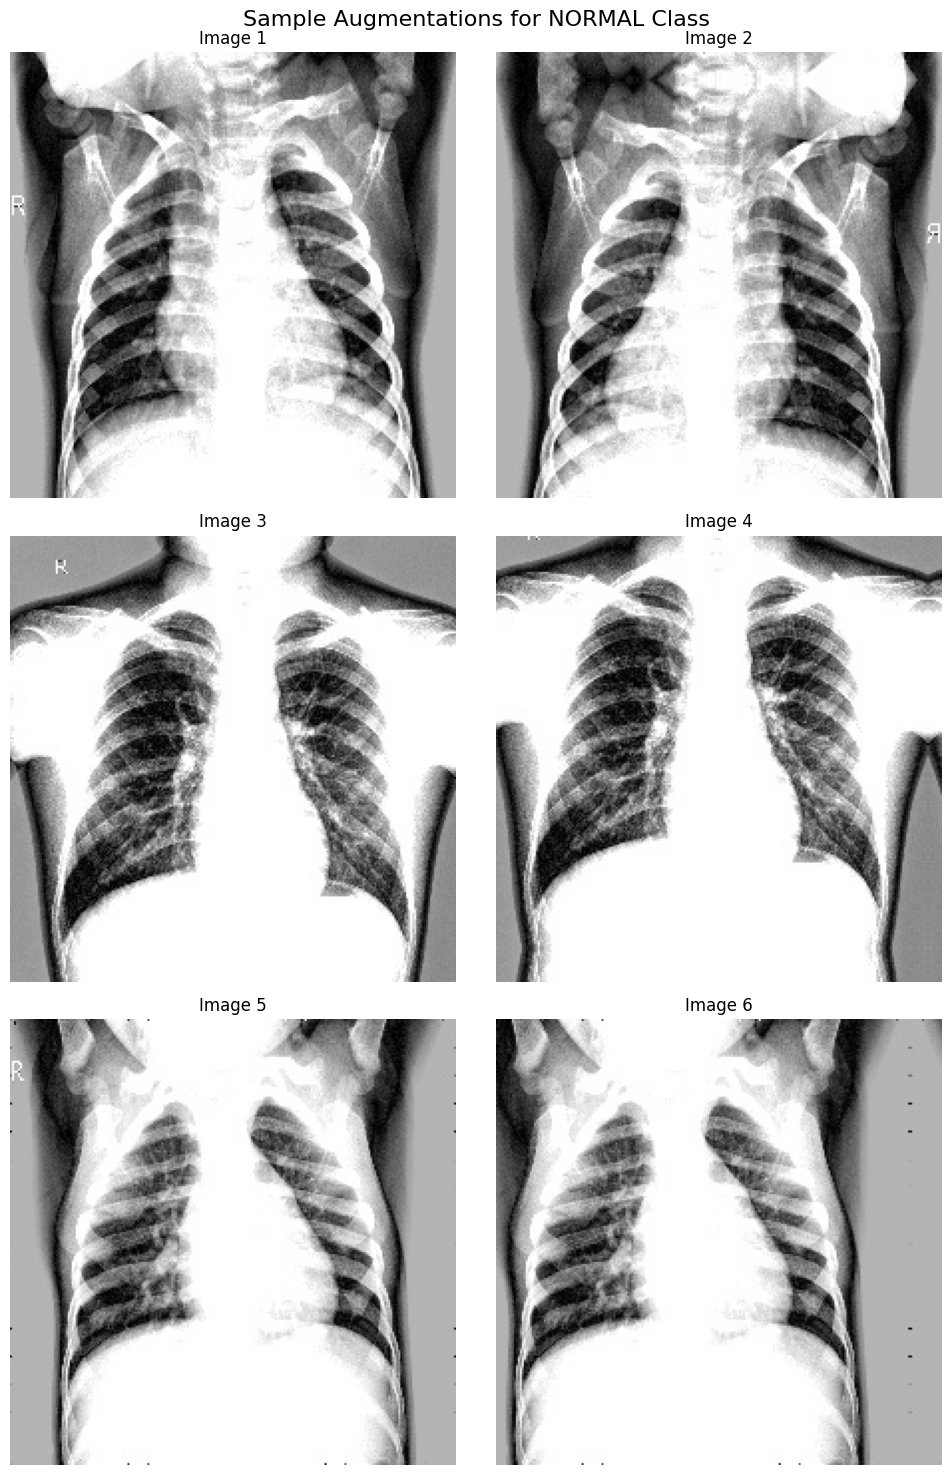

In [43]:
show_images_in_grid(images=images_to_show, cols=2, header_title="Sample Augmentations for NORMAL Class")

In [44]:
data_paths = {
    'train': {
        'NORMAL': os.path.join(DATA_DIR, 'train', 'NORMAL'),
        'PNEUMONIA': os.path.join(DATA_DIR, 'train', 'PNEUMONIA')
    },
    'val': {
        'NORMAL': os.path.join(DATA_DIR, 'val', 'NORMAL'),
        'PNEUMONIA': os.path.join(DATA_DIR, 'val', 'PNEUMONIA')
    },
    'test': {
        'NORMAL': os.path.join(DATA_DIR, 'test', 'NORMAL'),
        'PNEUMONIA': os.path.join(DATA_DIR, 'test', 'PNEUMONIA')
    }
}

In [47]:
# Verify final distribution
final_train_normal = len(list_folder(data_paths['train']['NORMAL']))
final_train_pneumonia = len(list_folder(data_paths['train']['PNEUMONIA']))
final_val_normal = len(list_folder(data_paths['val']['NORMAL']))
final_val_pneumonia = len(list_folder(data_paths['val']['PNEUMONIA']))
final_test_normal = len(list_folder(data_paths['test']['NORMAL']))
final_test_pneumonia = len(list_folder(data_paths['test']['PNEUMONIA']))

train_total = final_train_normal + final_train_pneumonia
val_total = final_val_normal + final_val_pneumonia
test_total = final_test_normal + final_test_pneumonia
grand_total = train_total + val_total + test_total

print("=" * 80)
print("Final Dataset Distribution")
print("=" * 80)
print(f"{'Split':<8} {'NORMAL':<10} {'PNEUMONIA':<12} {'Total':<8} {'%NORMAL':<10} {'%PNEUMONIA':<12} {'Split %':<8}")
print("-" * 80)
print(f"{'Train':<8} {final_train_normal:<10} {final_train_pneumonia:<12} {train_total:<8} {round(final_train_normal/train_total*100):<10} {round(final_train_pneumonia/train_total*100):<12} {round(train_total/grand_total*100):<8}")
print(f"{'Val':<8} {final_val_normal:<10} {final_val_pneumonia:<12} {val_total:<8} {round(final_val_normal/val_total*100):<10} {round(final_val_pneumonia/val_total*100):<12} {round(val_total/grand_total*100):<8}")
print(f"{'Test':<8} {final_test_normal:<10} {final_test_pneumonia:<12} {test_total:<8} {round(final_test_normal/test_total*100):<10} {round(final_test_pneumonia/test_total*100):<12} {round(test_total/grand_total*100):<8}")
print("-" * 80)
print(f"{'Total':<8} {'':<10} {'':<12} {grand_total:<8}")

Final Dataset Distribution
Split    NORMAL     PNEUMONIA    Total    %NORMAL    %PNEUMONIA   Split % 
--------------------------------------------------------------------------------
Train    2991       2991         5982     50         50           77      
Val      237        640          877      27         73           11      
Test     238        642          880      27         73           11      
--------------------------------------------------------------------------------
Total                            7739    
